# Metropolis-Hastings Algorithm

In this tutorial, we implement the Metropolis-Hasting algorithm to sample from two probability distributions. The first distribution is the a mixture of two normal distributions in 2D and the second distribution is a banana-shaped distribution in 2D.

## 1. Mixtures of two normal distributions in 2D
### Probability density function

The probability density function (PDF) of the mixture of two normal distributions in 2D used in this tutorial
is given by:

$$
p(x) = \alpha \cdot \phi(x \mid \mu_1, \sigma_1) + (1 - \alpha) \cdot \phi(x \mid \mu_2, \sigma_2)
$$

where:
- $\phi(x \mid \mu, \sigma)$ is the PDF of the 2d normal distribution with mean $\mu$ and standard deviation $\sigma$. Here we assume that the standard deviation is the same in both dimensions and there is no correlation between the dimensions.
- $\alpha$ is the weight of the first normal distribution.
  
$\phi(x \mid \mu, \sigma)$ is given by:

$$
\phi(x \mid \mu, \sigma) = \frac{1}{2\pi\sigma^2} \exp\left(-\frac{1}{2\sigma^2} (x - \mu)^T(x - \mu)\right)
$$

In this tutorial, we use the following parameters:
- $\alpha = 0.5$
- $\mu_1 = [0, 0]$
- $\mu_2 = [5, -4]$
- $\sigma_1 = 1$
- $\sigma_2 = 1.5$

In [2]:
import jax.numpy as jnp
from jax import vmap, jit
import jax.random as jr
from tqdm import tqdm
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-talk')

In [3]:
def compute_prob_mixture_of_normal(
    x, alpha=0.5, mu1=jnp.array([0, 0]), mu2=jnp.array([5, -4]), sigma1=1, sigma2=1.5
):
    """ "
    Compute the log probability of a point x under the Gaussian Mixture Model

    Parameters
    ----------
    x : jnp.array
        A 2D point
    alpha : float
        The weight of the first Gaussian component
    mu1 : jnp.array
        The mean of the first Gaussian component
    mu2 : jnp.array
        The mean of the second Gaussian component
    sigma1 : float
        The standard deviation of the first Gaussian component for both dimensions, the covariance matrix is diagonal
    sigma2 : float
        The standard deviation of the second Gaussian component for both dimensions, the covariance matrix is diagonal
    """

    # Compute the probability of x under the first Gaussian component
    prob1 = jnp.exp(-0.5 * (jnp.linalg.norm(x - mu1) ** 2) / (sigma1**2)) / (
        2 * jnp.pi * sigma1**2
    )

    # Compute the probability of x under the second Gaussian component
    prob2 = jnp.exp(-0.5 * (jnp.linalg.norm(x - mu2) ** 2) / (sigma2**2)) / (
        2 * jnp.pi * sigma2**2
    )

    # Compute the probability of x under the Gaussian Mixture Model
    prob = alpha * prob1 + (1 - alpha) * prob2

    return prob

Plot the PDF of the mixture of two normal distributions to visualize the distribution. The distribution has two modes, one at the origin and the other at $(5, -4)$. The two modes are separated by a region of low probability density.

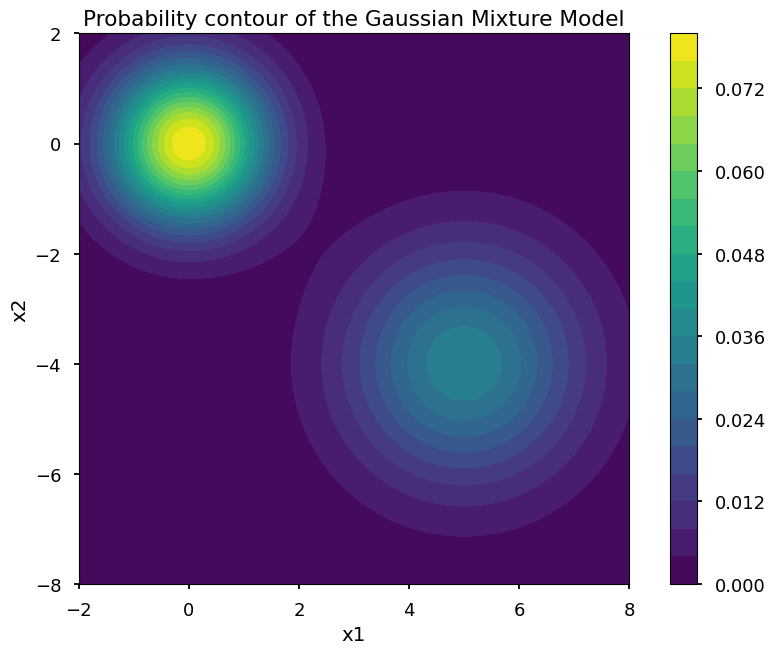

In [4]:
## plot contour of the probability
x1 = jnp.linspace(-2, 8, 100)
x2 = jnp.linspace(-8, 2, 100)

X1, X2 = jnp.meshgrid(x1, x2)
X = jnp.stack([X1, X2], axis=-1)

prob = vmap(vmap(compute_prob_mixture_of_normal))(X)
plt.contourf(X1, X2, prob, 20)
plt.colorbar()
plt.gca().set_aspect("equal")
plt.xlabel("x1")
plt.ylabel("x2")
plt.title("Probability contour of the Gaussian Mixture Model")
plt.show()

### Sample using Metropolis-Hastings algorithm

In [5]:
def genrate_proposal_mixture_of_normal(key, x):
    """Propose a new point x' given the current point x"""

    return x + jr.normal(key, (2,))


@jit
def one_step_mixture_of_normal(key, x):
    """Perform one step of the Metropolis-Hastings algorithm"""

    ## Generate a proposal
    subkey, key = jr.split(key)
    x_proposal = genrate_proposal_mixture_of_normal(subkey, x)

    ## Compute the acceptance probability
    p_x = compute_prob_mixture_of_normal(x)
    p_x_proposal = compute_prob_mixture_of_normal(x_proposal)
    accept_prob = jnp.min(jnp.array([1, p_x_proposal / p_x]))

    ## Accept or reject the proposal
    u = jr.uniform(key)
    x_new = jnp.where(u < accept_prob, x_proposal, x)

    return x_new

Run the Metropolis-Hastings algorithm

In [6]:
## generate a random initial point
key = jr.PRNGKey(0)
subkey1, subkey2, key = jr.split(key, 3)
x_init = jnp.concatenate(
    [
        jr.uniform(subkey1, (1,), minval=-2, maxval=8),
        jr.uniform(subkey2, (1,), minval=-8, maxval=2),
    ]
)
print(f"Initial point: {x_init}")

## generate samples
num_samples = 3000
samples = [x_init]
for i in tqdm(range(num_samples)):
    key, subkey = jr.split(key)
    x_init = one_step_mixture_of_normal(subkey, x_init)
    samples.append(x_init)

samples = jnp.stack(samples)

Initial point: [ 6.4231415 -7.927062 ]


100%|██████████| 3000/3000 [00:00<00:00, 12021.82it/s]


Plot samples

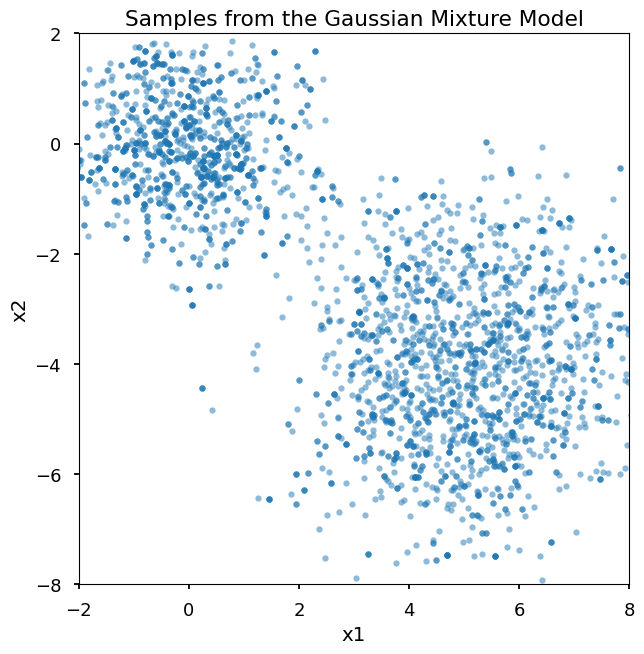

In [7]:
plt.plot(samples[:, 0], samples[:, 1], ".", alpha=0.5)
plt.xlim(-2, 8)
plt.ylim(-8, 2)
plt.gca().set_aspect("equal")
plt.xlabel("x1")
plt.ylabel("x2")
plt.title("Samples from the Gaussian Mixture Model")
plt.show()

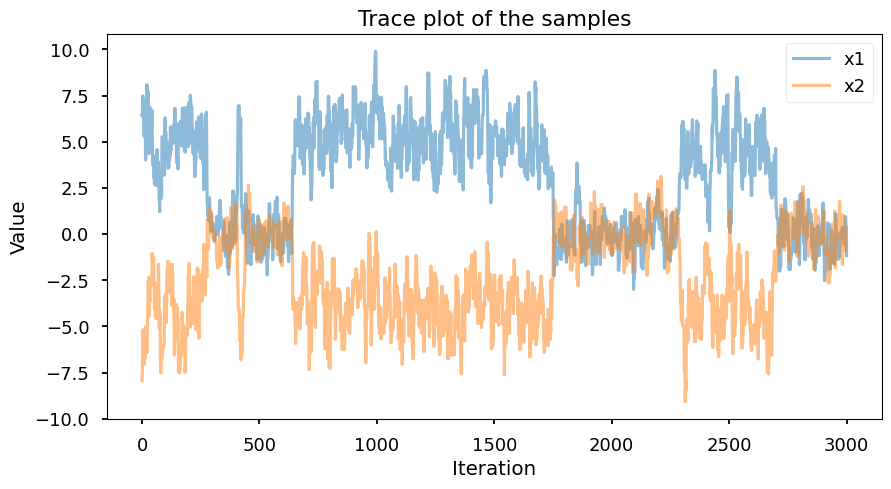

In [8]:
fig = plt.figure(figsize=(10, 5))
plt.clf()
plt.plot(samples[:, 0], label="x1", alpha=0.5)
plt.plot(samples[:, 1], label="x2", alpha=0.5)
plt.xlabel("Iteration")
plt.ylabel("Value")
plt.legend()
plt.title("Trace plot of the samples")
plt.show()


## 2. Banana-shaped distribution
### Probability density function

The probability density function (PDF) of the banana-shaped distribution is given by:

$$
p(x_1, x_2) = \frac{1}{2\pi\sigma_1\sigma_2} \exp\left(-\frac{1}{2} \frac{x_1^2}{\sigma_1^2} \right) + \exp\left(-\frac{1}{2}\frac{(x_2 - a x_1^2)^2}{\sigma_2^2}\right)
$$

where:
- $ \sigma_1 $ and $ \sigma_2 $ are the standard deviations.
- $ a $ is a parameter that controls the curvature of the banana shape.

In this tutorial, we use the following parameters:
- $ a = 0.25 $
- $ \sigma_1 = 2 $
- $ \sigma_2 = 0.5 $

Define the function to compute the PDF of the banana-shaped distribution.

In [9]:
def compute_prob_banana_dist(x, a = 0.25, sigma1 = 2, sigma2 = 0.5):
    x1, x2 = x[0], x[1]
    prob = jnp.exp(-0.5 * x1**2 / sigma1**2 - 0.5 * (x2 - a * x1**2)**2 / sigma2**2)
    return prob


Visualize the PDF of the banana-shaped distribution.

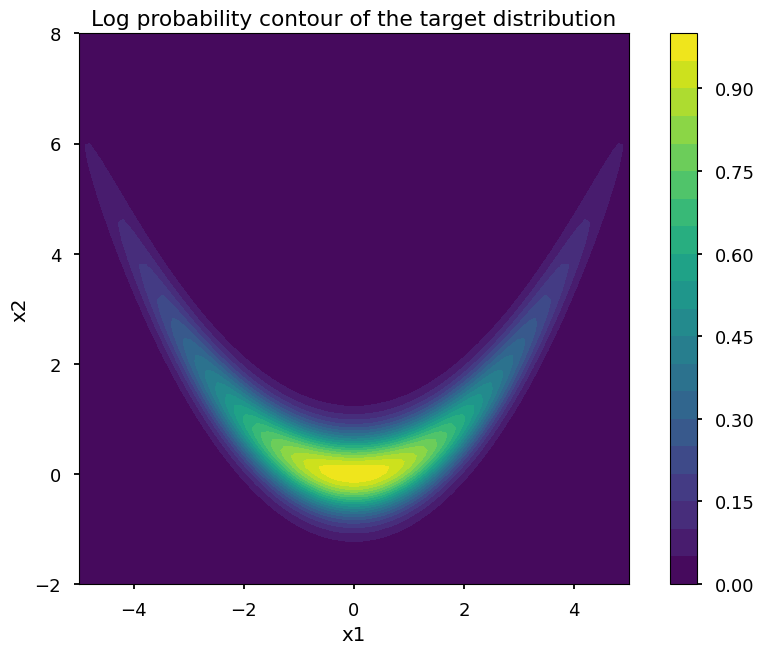

In [10]:
x1 = jnp.linspace(-5, 5, 100)
x2 = jnp.linspace(-2, 8, 100)

X1, X2 = jnp.meshgrid(x1, x2)
X = jnp.stack([X1, X2], axis=-1)

prob = vmap(vmap(compute_prob_banana_dist))(X)
plt.contourf(X1, X2, prob, 20)
plt.colorbar()
plt.gca().set_aspect("equal")
plt.xlabel("x1")
plt.ylabel("x2")
plt.title("Log probability contour of the target distribution")
plt.show()

### Sample using Metropolis-Hastings algorithm

In [11]:
def generate_proposal_banana(key, x):
    return x + jr.normal(key, (2,)) * jnp.array([0.5, 0.5])

@jit
def one_step_banana(key, x):
    subkey, key = jr.split(key)
    x_proposal = generate_proposal_banana(subkey, x)
    p_x = compute_prob_banana_dist(x)
    p_x_proposal = compute_prob_banana_dist(x_proposal)

    accept_prob = jnp.min(jnp.array([1, p_x_proposal / p_x]))   
    
    u = jr.uniform(key)
    x_new = jnp.where(u < accept_prob, x_proposal, x)

    return x_new


Run the Metropolis-Hastings algorithm

In [12]:
## generate a random initial point
subkey1, subkey2, key = jr.split(key, 3)

x_init = jnp.concatenate(
    [
        jr.uniform(subkey1, (1,), minval=-5, maxval=5),
        jr.uniform(subkey2, (1,), minval=-2, maxval=8),
    ]
)
print(f"Initial point: {x_init}")

## generate samples
num_samples = 3000
samples = [x_init]
for i in tqdm(range(num_samples)):
    key, subkey = jr.split(key)
    x_init = one_step_banana(subkey, x_init)
    samples.append(x_init)
samples = jnp.stack(samples)

Initial point: [-2.7357197  2.219818 ]


100%|██████████| 3000/3000 [00:00<00:00, 14819.20it/s]


Plot samples

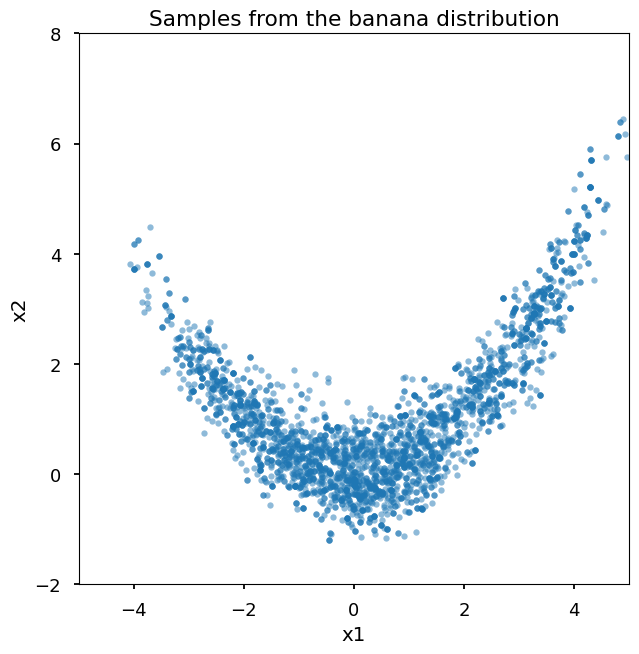

In [13]:
plt.plot(samples[:, 0], samples[:, 1], ".", alpha=0.5)
plt.xlim(-5, 5)
plt.ylim(-2, 8)
plt.gca().set_aspect("equal")
plt.xlabel("x1")
plt.ylabel("x2")
plt.title("Samples from the banana distribution")
plt.show()

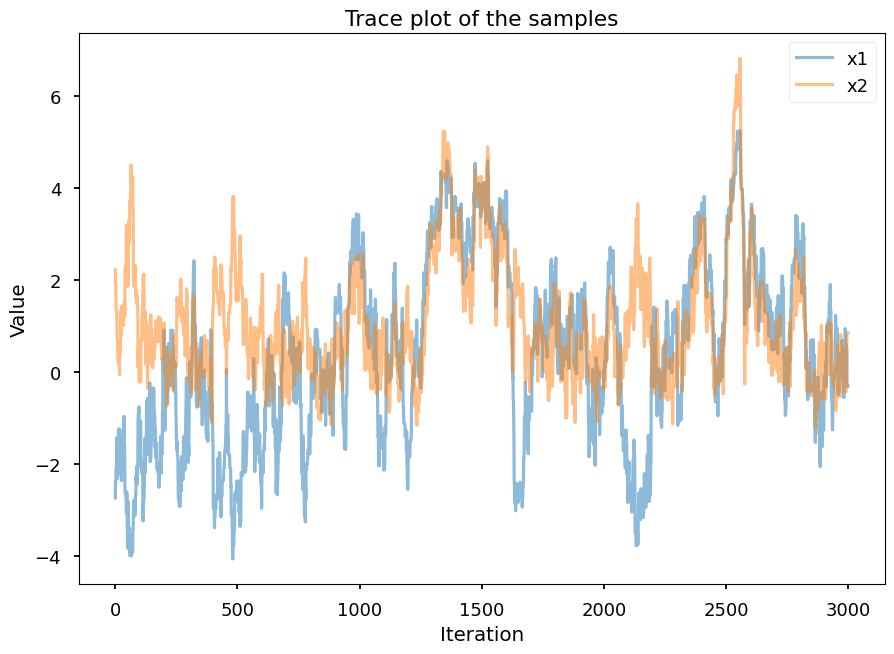

In [14]:
plt.plot(samples[:, 0], label="x1", alpha=0.5)
plt.plot(samples[:, 1], label="x2", alpha=0.5)
plt.xlabel("Iteration")
plt.ylabel("Value")
plt.legend()
plt.title("Trace plot of the samples")
plt.show()